## Prerequisites

In [1]:
# pip install spacy==2.2.0               # (install spacy for lemmatization)
# conda install -c conda-forge pyldavis  # (if you use aconda to install pyLADvis)
# conda install gensim==3.8.3            # (intall gesim for topic modelling, make sure the version of gensim is 3.8.3 to support Mallet)
# pip install pyLDAvis                   # (install pyLDAvis for topic modelling visulisation)     

In [73]:
import pandas as pd
import numpy as np
import nltk; nltk.download('stopwords') 
from nltk.corpus import stopwords      # import stop words
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\suhao\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Visualisation

import pyLDAvis
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

F:\Anaconda\lib\site-packages\sklearn\decomposition\_lda.py:28: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  EPS = np.finfo(np.float).eps


## Import dataset, data wrangling and overview

In [5]:
WHONEWS = pd.read_excel('./WHONEWS.xlsx')
WHONEWS.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15533 entries, 0 to 15532
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Title      15533 non-null  object
 1   Link       15533 non-null  object
 2   Timestamp  15533 non-null  object
 3   Category   15533 non-null  object
 4   Content    15419 non-null  object
dtypes: object(5)
memory usage: 606.9+ KB


In [6]:
# drop missing values
WHO = WHONEWS.dropna(how = 'any')             
WHO = WHO.drop_duplicates(subset = 'Content') # drop duplicate rows
WHO['Word_count'] = WHO['Content'].str.count(' ') + 1
WHO.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 196 entries, 0 to 5928
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Title       196 non-null    object
 1   Link        196 non-null    object
 2   Timestamp   196 non-null    object
 3   Category    196 non-null    object
 4   Content     196 non-null    object
 5   Word_count  196 non-null    int64 
dtypes: int64(1), object(5)
memory usage: 10.7+ KB


In [7]:
WHO = WHO.reset_index()
WHO.head()

,index,Title,Link,Timestamp,Category,Content,Word_count
0,0,COVID-19 subcommittee of the WHO Global Adviso...,https://www.who.int/news/item/09-07-2021-gacvs...,9 July 2021,Statement,"On 26 May 2021, the COVID-19 subcommittee of t...",1001
1,1,WHO recommends life-saving interleukin-6 recep...,https://www.who.int/news/item/06-07-2021-who-r...,6 July 2021,News release,The World Health Organization (WHO) has update...,463
2,4,First Meeting of the Task Force on COVID-19 Va...,https://www.who.int/news/item/30-06-2021-first...,30 June 2021,Statement,"The Heads of the World Bank Group, Internation...",398
3,6,Health Workforce in COVID-19 Action Series: Ti...,https://www.who.int/news/item/30-06-2021-healt...,30 June 2021,Departmental news,"Over a year into the pandemic, health systems ...",564
4,12,"Directors General of WHO, WIPO and the WTO agr...",https://www.who.int/news/item/24-06-2021-direc...,24 June 2021,Joint News Release,"On June 15, 2021, we, the Directors General of...",663


#### Word count

In [81]:
# Word count
WHO['Word_count'].sum( ) 

155825

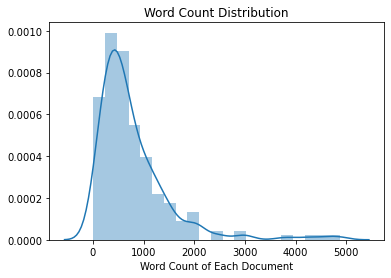

In [87]:
# Word count distribution
import seaborn as sns
ax1 = sns.distplot(WHO['Word_count'])
ax1.set(title = 'Word Count Distribution',
        xlabel = 'Word Count of Each Document');

In [9]:
WHONEWS = WHO[['Title', 'Content']]

## Tokenization

In [76]:
data = WHONEWS.Content.values.tolist()
data[1]

'The World Health Organization (WHO) has updated its patient care guidelines to include interleukin-6 receptor blockers, a class of medicines that are lifesaving in patients who are severely or critically ill with COVID-19, especially when administered\n    alongside corticosteroids.\xa0These were the findings from a prospective and a living network meta-analysis initiated by WHO, the largest such analysis on the drugs to date. Data from over 10\xa0000 patients enrolled in 27 clinical trials were considered.\xa0These are the first drugs found to be effective against COVID-19 since corticosteroids were\xa0recommended by WHO\xa0in September 2020.\xa0Patients severely or critically ill with COVID-19 often suffer from an overreaction of the immune system, which can be very harmful to the patient’s health. Interleukin-6 blocking drugs – tocilizumab and sarilumab – act to suppress this\n    overreaction.\xa0\xa0The prospective and living network meta-analyses showed that in severely or criti

In [11]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence).encode('utf-8'), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))
data_words[:1]

[['on',
  'may',
  'the',
  'covid',
  'subcommittee',
  'of',
  'the',
  'who',
  'global',
  'advisory',
  'committee',
  'on',
  'vaccine',
  'safety',
  'gacvs',
  'issued',
  'statement',
  'reviewing',
  'initial',
  'reports',
  'of',
  'mild',
  'myocarditis',
  'following',
  'covid',
  'mrna',
  'vaccines',
  'myocarditis',
  'is',
  'an',
  'inflammation',
  'of',
  'the',
  'heart',
  'muscle',
  'and',
  'pericarditis',
  'is',
  'an',
  'inflammation',
  'of',
  'the',
  'lining',
  'that',
  'surrounds',
  'the',
  'heart',
  'while',
  'they',
  'can',
  'lead',
  'to',
  'serious',
  'illness',
  'they',
  'are',
  'often',
  'mild',
  'and',
  'respond',
  'well',
  'to',
  'conservative',
  'treatment',
  'more',
  'data',
  'have',
  'become',
  'available',
  'since',
  'the',
  'gacvs',
  'statement',
  'of',
  'may',
  'with',
  'more',
  'countries',
  'reporting',
  'myocarditis',
  'and',
  'pericarditis',
  'in',
  'individuals',
  'who',
  'received',
  'cov

## Bigram and trigram

In [12]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)
# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['on', 'may', 'the', 'covid', 'subcommittee', 'of', 'the', 'who', 'global', 'advisory_committee', 'on', 'vaccine', 'safety', 'gacvs', 'issued', 'statement', 'reviewing', 'initial', 'reports', 'of', 'mild', 'myocarditis', 'following', 'covid', 'mrna', 'vaccines', 'myocarditis', 'is', 'an', 'inflammation', 'of', 'the', 'heart', 'muscle', 'and', 'pericarditis', 'is', 'an', 'inflammation', 'of', 'the', 'lining', 'that', 'surrounds', 'the', 'heart', 'while', 'they', 'can', 'lead', 'to', 'serious', 'illness', 'they', 'are', 'often', 'mild', 'and', 'respond', 'well', 'to', 'conservative', 'treatment', 'more', 'data', 'have', 'become', 'available', 'since', 'the', 'gacvs', 'statement', 'of', 'may', 'with', 'more', 'countries', 'reporting', 'myocarditis', 'and', 'pericarditis', 'in', 'individuals', 'who', 'received', 'covid', 'mrna', 'vaccines', 'the', 'reported', 'cases', 'have', 'typically', 'occurred', 'within', 'days', 'of', 'vaccination', 'more', 'commonly', 'among', 'younger', 'males', 'a

## Remove Stopwords, Make Bigrams and Trigrams, and Lemmatisation

In [13]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [14]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['may', 'subcommittee', 'issue', 'statement', 'review', 'initial', 'report', 'mild', 'myocarditis', 'follow', 'covid', 'vaccine', 'myocarditis', 'inflammation', 'heart', 'muscle', 'pericarditis', 'inflammation', 'lining', 'surround', 'heart', 'lead', 'serious', 'illness', 'often', 'mild', 'respond', 'conservative', 'treatment', 'datum', 'become', 'available', 'statement', 'may', 'country', 'report', 'pericarditis', 'individual', 'receive', 'covid', 'vaccine', 'report', 'case', 'typically', 'occur', 'day', 'vaccination', 'commonly', 'young', 'male', 'often', 'follow', 'second', 'dose', 'covid', 'vaccine', 'strong', 'report', 'recently', 'covid', 'vaccine', 'state', 'however', 'immunization', 'practice', 'conclude', 'benefit', 'covid', 'vaccine', 'continue', 'outweigh', 'risk', 'myocarditis', 'pericarditis', 'even', 'young', 'people', 'accord', 'datum', 'vaccine', 'adverse_event', 'report', 'system', 'vaer', 'approximately', 'case', 'myocarditis', 'second', 'dose', 'male', 'case', 'fema

##  Create the Dictionary and Corpus needed for Topic Modeling

In [15]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 2), (1, 1), (2, 1), (3, 1), (4, 2), (5, 1), (6, 2), (7, 2), (8, 1), (9, 1), (10, 1), (11, 2), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 3), (21, 1), (22, 2), (23, 4), (24, 2), (25, 1), (26, 8), (27, 1), (28, 1), (29, 2), (30, 1), (31, 1), (32, 1), (33, 1), (34, 2), (35, 1), (36, 1), (37, 2), (38, 1), (39, 1), (40, 1), (41, 1), (42, 2), (43, 2), (44, 1), (45, 4), (46, 1), (47, 3), (48, 1), (49, 22), (50, 1), (51, 1), (52, 1), (53, 8), (54, 2), (55, 2), (56, 1), (57, 1), (58, 1), (59, 4), (60, 1), (61, 1), (62, 2), (63, 1), (64, 1), (65, 1), (66, 1), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1), (72, 1), (73, 2), (74, 1), (75, 1), (76, 1), (77, 1), (78, 13), (79, 1), (80, 1), (81, 2), (82, 1), (83, 3), (84, 1), (85, 1), (86, 3), (87, 1), (88, 1), (89, 2), (90, 3), (91, 1), (92, 2), (93, 1), (94, 2), (95, 3), (96, 1), (97, 3), (98, 1), (99, 2), (100, 1), (101, 1), (102, 1), (103, 1), (104, 1), (105, 2), (106, 1), (107, 1), (108, 1), (109, 1), (110, 

## Building Mallet's LDA 

Download the zip file http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip, unzip it on the C drive

In [16]:
import os
os.environ.update({'MALLET_HOME':r'C:/mallet-2.0.8/'})

In [17]:
mallet_path = 'C:/mallet-2.0.8/bin/mallet' # update this path,remove ""Read only" permission of the folder after unzipping.unzip- > Right click on "mallet-2.0.8" -> Uncheck "Read only"
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=10, id2word=id2word)

In [18]:
# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)


Coherence Score:  0.38084933181702724


#### Hyperameter tuning: tuning the number of topics to increase Coherence Score

In [19]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [20]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

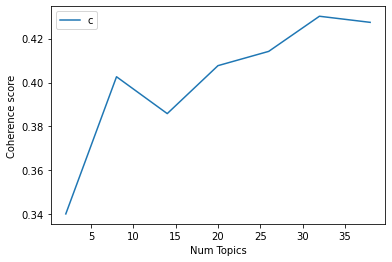

In [21]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [22]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3402
Num Topics = 8  has Coherence Value of 0.4026
Num Topics = 14  has Coherence Value of 0.3859
Num Topics = 20  has Coherence Value of 0.4077
Num Topics = 26  has Coherence Value of 0.4142
Num Topics = 32  has Coherence Value of 0.4302
Num Topics = 38  has Coherence Value of 0.4274


In [23]:
# Select the optimal model whose number of topics = 20
optimal_model = model_list[3]

In [24]:
lda_model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(optimal_model) # convert the mallet LDA model into a Gensim LDA model

## Visualisation

In [26]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
9      0.073054 -0.167455       1        1  9.089419
7     -0.025096  0.031531       2        1  6.948525
15    -0.030242  0.072966       3        1  6.774176
3     -0.186084  0.101646       4        1  6.609651
6     -0.272694 -0.060247       5        1  5.276101
0      0.114946  0.042632       6        1  5.143646
2      0.106347 -0.070717       7        1  4.954833
16    -0.042967  0.059149       8        1  4.856990
10     0.120425 -0.328046       9        1  4.554832
8      0.179334 -0.185274      10        1  4.529707
4     -0.253493 -0.098714      11        1  4.504555
12    -0.027670  0.097170      12        1  4.448927
5      0.198072  0.145792      13        1  4.396727
11     0.128810  0.067293      14        1  4.360186
1     -0.056536  0.084654      15        1  4.241356
14    -0.078911 -0.008219      16        1  4.178785
19     0.099466  0.169014      17        1  4.025625
18     0.068601  0.156263      18        1  3.820194
17    -0.117071 -0.105428      19        1  3.716530
13     0.001711 -0.004009      20        1  3.569237, topic_info=         Term         Freq        Total Category  logprob  loglift
225   vaccine  1425.000000  1425.000000  Default  30.0000  30.0000
84     health  1588.000000  1588.000000  Default  29.0000  29.0000
49      covid  1716.000000  1716.000000  Default  28.0000  28.0000
147    people   576.000000   576.000000  Default  27.0000  27.0000
596    global   846.000000   846.000000  Default  26.0000  26.0000
..        ...          ...          ...      ...      ...      ...
318  platform    21.971996    81.503930  Topic20  -4.7592   2.0219
163    public    28.563595   373.806987  Topic20  -4.4968   0.7612
58    develop    26.366395   241.361331  Topic20  -4.5769   1.1186
140      open    19.774797    50.940990  Topic20  -4.8645   2.3866
56     design    19.774797    61.414485  Topic20  -4.8645   2.1996

[1665 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
681       1  0.913127      absorb
3818     16  1.025651       abuse
351       1  0.093381  accelerate
351       2  0.093381  accelerate
351       3  0.410875  accelerate
...     ...       ...         ...
900       8  0.924090   yoshihide
233      11  0.872132       young
233      13  0.124590       young
679      11  0.991296       youth
2392     11  1.070844        zoom

[2415 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 8, 16, 4, 7, 1, 3, 17, 11, 9, 5, 13, 6, 12, 2, 15, 20, 19, 18, 14])

#### The most frequent 10 words of each topic

In [27]:
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.073*"service" + 0.070*"child" + 0.059*"country" + 0.035*"health" + '
  '0.031*"disruption" + 0.024*"report" + 0.022*"pandemic" + 0.019*"survey" + '
  '0.019*"school" + 0.018*"death"'),
 (1,
  '0.091*"health" + 0.065*"people" + 0.048*"disease" + 0.032*"ensure" + '
  '0.026*"service" + 0.023*"programme" + 0.020*"control" + 0.020*"affect" + '
  '0.020*"covid" + 0.017*"essential"'),
 (2,
  '0.051*"case" + 0.032*"country" + 0.027*"response" + 0.025*"outbreak" + '
  '0.021*"level" + 0.018*"human" + 0.017*"report" + 0.017*"health" + '
  '0.016*"transmission" + 0.015*"regional"'),
 (3,
  '0.059*"work" + 0.049*"global" + 0.041*"world" + 0.033*"protect" + '
  '0.033*"covid" + 0.032*"provide" + 0.023*"partner" + 0.020*"make" + '
  '0.017*"response" + 0.016*"follow"'),
 (4,
  '0.069*"people" + 0.036*"support" + 0.035*"global" + 0.024*"young" + '
  '0.022*"pandemic" + 0.020*"family" + 0.018*"world" + 0.018*"community" + '
  '0.017*"youth" + 0.016*"organization"'),
 (5,
  '0.080*"covid" + 

#### Dominant topic in each document

In [46]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_Number', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic

,Document_Number,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,5.0,0.5127,"covid, report, risk, follow, datum, continue, ...","On 26 May 2021, the COVID-19 subcommittee of t..."
1,1,11.0,0.3817,"care, covid, country, patient, treatment, incl...",The World Health Organization (WHO) has update...
2,2,9.0,0.1252,"vaccine, country, covax, dose, gavi, access, s...","The Heads of the World Bank Group, Internation..."
3,3,12.0,0.2562,"health, country, covid, pandemic, strengthen, ...","Over a year into the pandemic, health systems ..."
4,4,18.0,0.1682,"covid, medical, provide, national, ensure, gui...","On June 15, 2021, we, the Directors General of..."
...,...,...,...,...,...
191,191,0.0,0.2180,"service, child, country, health, disruption, r...",GENEVA/NEW YORK - The International Federation...
192,192,16.0,0.1979,"covid, response, community, health, pandemic, ...","As of today’s reports, the global number of co..."
193,193,16.0,0.2521,"covid, response, community, health, pandemic, ...",As the current outbreak of the Coronavirus Dis...
194,194,2.0,0.3494,"case, country, response, outbreak, level, huma...",Good afternoon everyone and apologies for bein...


#### The most representative document for each topic¶

In [37]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head(5)

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.4584,"service, child, country, health, disruption, r...",With the number of under-five deaths at an all...
1,1.0,0.4857,"health, people, disease, ensure, service, prog...",As the world comes together to tackle the COVI...
2,2.0,0.5059,"case, country, response, outbreak, level, huma...",This statement is no longer maintained. An upd...
3,3.0,0.3129,"work, global, world, protect, covid, provide, ...",WHO and UNICEF today announced an agreement to...
4,4.0,0.6172,"people, support, global, young, pandemic, fami...",Initiative led by the world’s six largest yout...
